<a href="https://colab.research.google.com/github/Tejas163/Iris_Serverless/blob/main/iris_train_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install -U hopsworks --quiet

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import hopsworks

Get the feature view from hopsworks

In [12]:
project = hopsworks.login(project='tsk001')
fs = project.get_feature_store()

try:
    feature_view = fs.get_feature_view(name="iris", version=1)
except:
    iris_fg = fs.get_feature_group(name="iris", version=1)
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(name="iris",
                                      version=1,
                                      description="Read from Iris flower dataset",
                                      labels=["variety"],
                                      query=query)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/946324
Connected. Call `.close()` to terminate connection gracefully.


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os

# Check if running in GitHub Actions
is_github_actions = os.environ.get('GITHUB_ACTIONS') == 'true'

if is_github_actions:
    base_path = './assets'  # Relative to the repository root
else:
    base_path = '/content/drive/MyDrive/assets'  # Google Colab path

# Use base_path to construct file paths throughout the notebook
# Example: file_path = os.path.join(base_path, 'Setosa.png')

In [14]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.52s) 


Model fitting

In [15]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [16]:
y_pred = model.predict(X_test)
y_pred

array(['Setosa', 'Setosa', 'Setosa', 'Virginica', 'Versicolor', 'Setosa',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Setosa',
       'Virginica', 'Virginica', 'Versicolor', 'Setosa', 'Versicolor',
       'Versicolor', 'Virginica', 'Virginica', 'Setosa', 'Setosa',
       'Versicolor', 'Virginica', 'Setosa', 'Setosa', 'Virginica',
       'Versicolor', 'Setosa', 'Virginica', 'Setosa', 'Versicolor'],
      dtype=object)

In [17]:
from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14.0}, 'Versicolor': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.823529411764706, 'support': 8.0}, 'Virginica': {'precision': 0.875, 'recall': 0.7777777777777778, 'f1-score': 0.823529411764706, 'support': 9.0}, 'accuracy': 0.9032258064516129, 'macro avg': {'precision': 0.8842592592592592, 'recall': 0.8842592592592592, 'f1-score': 0.8823529411764707, 'support': 31.0}, 'weighted avg': {'precision': 0.9063620071684587, 'recall': 0.9032258064516129, 'f1-score': 0.9032258064516129, 'support': 31.0}}


In [18]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)
print(results)

[[14  0  0]
 [ 0  7  1]
 [ 0  2  7]]


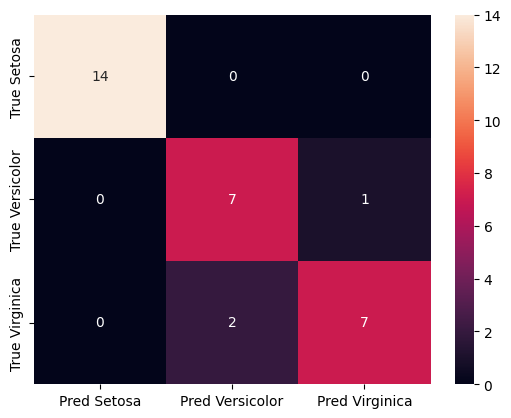

In [21]:
from matplotlib import pyplot

df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("/content/drive/MyDrive/assets/confusion_matrix.png")
fig.show()

##Register Model with Hopsworks Model Registry

In [22]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import hopsworks
import shutil

project =  hopsworks.login()
mr = project.get_model_registry()

# The 'iris_model' directory will be saved to the model registry
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/iris_model.pkl")
shutil.copyfile("/content/drive/MyDrive/assets/confusion_matrix.png", model_dir + "/confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

iris_model = mr.python.create_model(
    version=1,
    name="iris",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example,
    description="Iris Flower Predictor")

iris_model.save(model_dir)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/946324
Connected. Call `.close()` to terminate connection gracefully.


ModelRegistryException: Model with name iris and version 1 already exists